In [9]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np

A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward.

Each recurrent neuron has two sets of weights: one for the inputs x and
the other for the outputs of the previous time step y

we will look at some more complex
and powerful types of cells capable of learning longer patterns

<img src="https://www.researchgate.net/profile/Vidushi-Mishra/publication/324883736/figure/fig2/AS:621644821307392@1525223083712/Recurrent-neural-networkRNN-or-Long-Short-Term-MemoryLSTM-5616.png" width=400px/>

### Generate the Dataset

In [12]:
def generate_time_series(batch_size, n_steps) :
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)

    # each series is the sum of two sine waves of fixed amplitudes but random 
    # frequencies and phases, plus a bit of noise
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32) # [batch size, time steps, 1]

In [29]:
generate_time_series(10, 2).shape

(10, 2, 1)

In [30]:
np.random.seed(42)

n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # predict the last one
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [33]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [60]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    plt.grid(True)
    
    if y :
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred :
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    
    
    if x_label :
        plt.xlabel(x_label, fontsize=16)
    if y_label :
        plt.ylabel(y_label, fontsize=16, rotation=0)


    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [69]:
X_valid[0,:,0].shape # for each x instance

(50,)

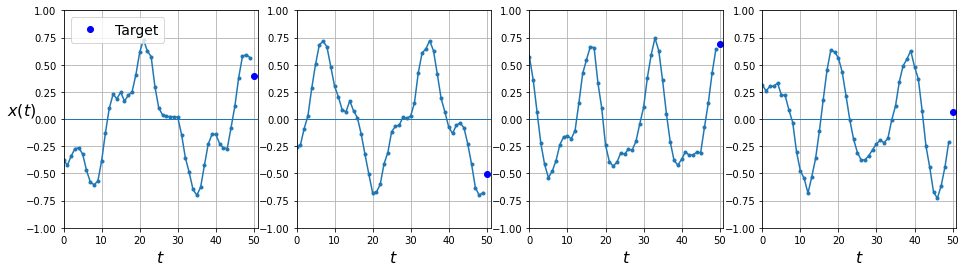

In [66]:
plt.figure(figsize=(16,4))
for col in range(4) :
    plt.subplot(1,4,col+1)
    plot_series(X_valid[col, :, 0], y_valid[col, 0], 
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

### Baseline Metrics 
Before we start using RNNs, it is often a good idea to have a few baseline
metrics : using **naive forcasting** concept is today is same as the yesterday, tomorrow same as today.

In [85]:
y_pred = X_valid[:, -1] # predict from the last value of x
baseline_mse = np.mean(np.square(y_pred - y_valid))
baseline_mse

0.020211367

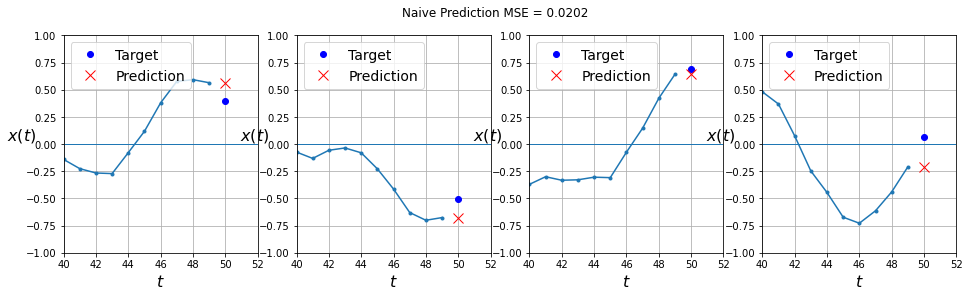

In [111]:
plt.figure(figsize=(16,4))
for sample in range(4) :
    plt.subplot(1,4,sample+1)
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
    plt.xlim([40,52])
    plt.suptitle(f'Naive Prediction MSE = {baseline_mse:.4f}')

## Implementing a Simple RNN

In [115]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.Sequential([ 
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 17/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 18/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 19/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 20/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0114 - val_loss: 0.0109


In [121]:
model_1_mse = model.evaluate(X_valid, y_valid)
model_1_mse

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

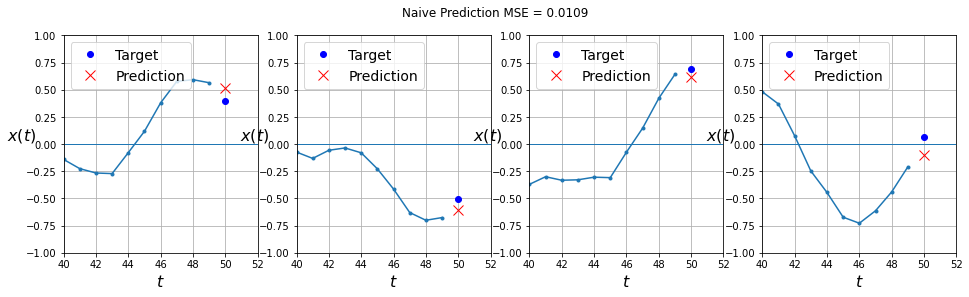

In [123]:
y_pred = model.predict(X_valid)
plt.figure(figsize=(16,4))
for sample in range(4) :
    plt.subplot(1,4,sample+1)
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
    plt.xlim([40,52])
    plt.suptitle(f'Naive Prediction MSE = {model_1_mse:.4f}')

## Deep RNNs 
stack multiple layers of cells

In [126]:
np.random.seed(42)
tf.random.set_seed(42)

model_2 = keras.models.Sequential([ 
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(20, return_sequences=True), # if stack need to return_sequences
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model_2.compile(loss='mse', optimizer='adam')
history_2 = model_2.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid))

219/219 [==============================] - 4s 20ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 15/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 16/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 17/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 18/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 19/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 20/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0032 - val_loss: 0.0029


In [127]:
model_2_mse = model_2.evaluate(X_valid, y_valid)
model_2_mse

63/63 [==============================] - 0s 6ms/step - loss: 0.0029


0.0029105644207447767

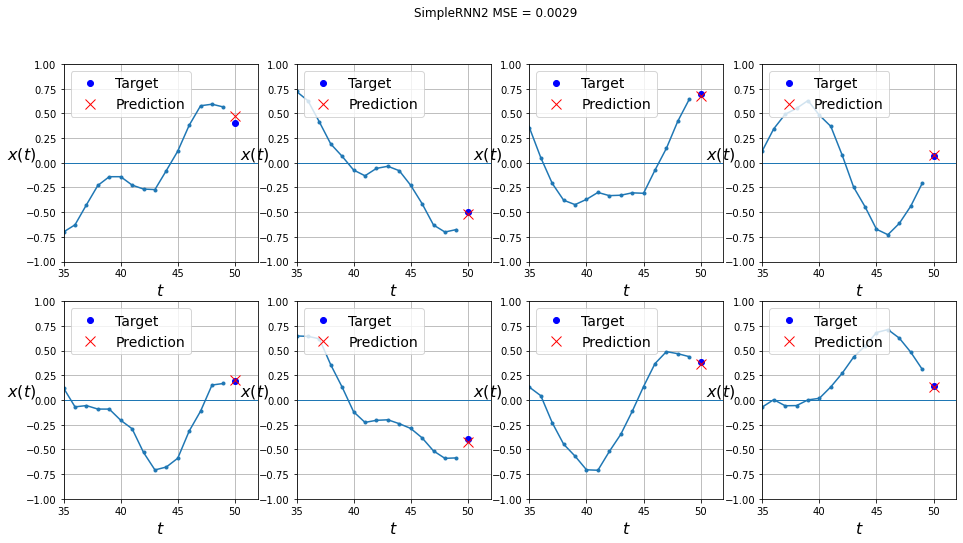

In [142]:
y_pred = model_2.predict(X_valid)
plt.figure(figsize=(16,8))
for sample in range(8) :
    plt.subplot(2,4,sample+1)
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
    plt.xlim([35,52])
    plt.suptitle(f'SimpleRNN2 MSE = {model_2_mse:.4f}')

> if predict just one is easy, we will make it harder

## Forecasting Several Steps Ahead

In [147]:
np.random.seed(7) # not 42

series = generate_time_series(1, n_steps+10)
series.shape # batch, x, dimention

(1, 60, 1)

In [217]:
X_new, y_true = series[:, :n_steps], series[:, n_steps:] # y is followed x
X = X_new
for next_step in range(10) :
    y_pred_one = model_2.predict(X[:, next_step:])[:, np.newaxis, :] # [0:], [1:], [2:] ... [10:]
    X = np.concatenate([X, y_pred_one], axis=1) # then concat the use the recently predicted y to predict next y 

y_pred = X[:, n_steps:] 

In [218]:
y_pred.shape

(1, 10, 1)

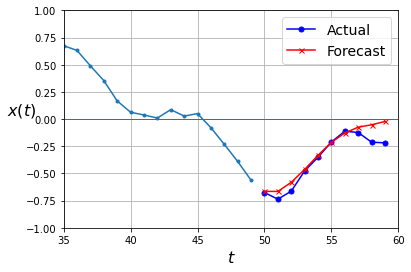

In [241]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1] # x data
    ahead = Y.shape[1] # y next predict
    plot_series(X[0,:, 0]) # first 50 x 
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0] , "bo-", label="Actual", markersize=5)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=5)
    plt.axis([35, n_steps + ahead, -1, 1]) # n_steps = 50
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, y_true, y_pred)

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [312]:
np.random.seed(42)

n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps+10) # let's make 10 prediction per time
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [259]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 10))

In [262]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = keras.Input(shape=(50,1))
x = keras.layers.SimpleRNN(20, return_sequences=True)(inputs)
x = keras.layers.SimpleRNN(20)(x)
outputs = keras.layers.Dense(10)(x)

model_ = keras.Model(inputs, outputs)
model_.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 50, 20)            440       
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [304]:
model_.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = model_.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

219/219 [==============================] - 3s 12ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 15/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 16/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 17/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0078 - val_loss: 0.0102
Epoch 18/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 19/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 20/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0077 - val_loss: 0.0071


In [305]:
# make prediction
series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_.predict(X_new)[..., np.newaxis]

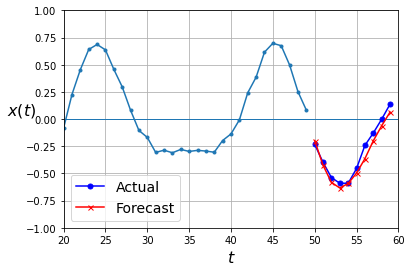

In [309]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.xlim([20,60]);

## Deep RNNs with Layer Norm